In [10]:
# Imports necessaris
import json
import os
import re
import pandas as pd
import openai

from pathlib import Path
from functools import lru_cache
from dotenv import load_dotenv
from typing import Optional, List, TypedDict
from duckduckgo_search import DDGS
from IPython.display import display, Image

from typing import TypedDict, Literal

from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate

from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_transformers import BeautifulSoupTransformer

In [11]:
# Dades de referència amb el model gpt-4.5
with open("resultats_4_5.json", "r", encoding="utf-8") as f:
    data_4_5 = json.load(f)

# Carreguem el dataset de notícies
file_path = '../final_dataset_v2.csv'  
# Step 3: Read the CSV file
df = pd.read_csv(file_path, low_memory=False)

In [12]:
# Creem una funció per trobar tots els articles que tenen almenys un "No" en compliment
def find_articles_with_no_compliment(data_json):
    # Dictionary to store article_id → full JSON for those with at least one "No" in compliment
    articles_with_no_dict = {}

    # Iterate through each article's analysis
    for article_id, criteria in data_json.items():
        for key, value in criteria.items():
            if isinstance(value, dict):
                if value.get("compliment", "").strip().lower() == "no":
                    articles_with_no_dict[article_id] = criteria
                    break  # Skip remaining keys for this article

    return articles_with_no_dict

# Ara una funció per comptar el nombre de criteris per cada tema
def count_criteria_by_topic(data_json):

    # Count compliments for each category across all articles
    category_counts = {}

    for article in data_json.values():
        for category, values in article.items():
            compliment = values.get("compliment", "").strip()
            if category not in category_counts:
                category_counts[category] = {"Sí": 0, "No": 0, "No aplica": 0}
            if compliment in category_counts[category]:
                category_counts[category][compliment] += 1

    # Convert the result to a DataFrame
    df_category_counts = pd.DataFrame.from_dict(category_counts, orient='index')
    df_category_counts.index.name = "Category"
    return df_category_counts

def clean_json_output(raw_output):
    # Remove triple backticks and optional "json" marker
    cleaned = re.sub(r"^```(?:json)?\s*|\s*```$", "", raw_output.strip(), flags=re.IGNORECASE | re.MULTILINE)
    return cleaned

class Criterion(TypedDict):
    compliment: Literal["Sí", "No", "No aplica"]
    comentari: str

class GeneralEvaluation(TypedDict):
    pluralisme: Criterion
    diversitat: Criterion
    minories: Criterion
    paritat_equilibri_genere: Criterion

class QualitatResultat(TypedDict):
    compromis: Criterion
    veracitat_rigor: Criterion
    independencia: Criterion
    imparcialitat_neutralitat: Criterion

class DenominacionsResultat(TypedDict):
    denominacions: Criterion

class LlenguatgeResultat(TypedDict):
    model_llenguatge: Criterion
    adequacio: Criterion

In [13]:
# Ara cal triar el model a avaluar i afegir la key

# TRIAR EL MODEL
llm = ChatOpenAI(model="gpt-4.1", temperature=0)

# CARREGAR KEY
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
openai.api_key = os.getenv('OPENAI_API_KEY')

# Models disponiblees de openai 
models = openai.models.list()
for model in models:
    print(model.id)

gpt-4-0613
gpt-4
gpt-3.5-turbo
o4-mini-deep-research-2025-06-26
o3-pro-2025-06-10
o4-mini-deep-research
o3-deep-research
o3-deep-research-2025-06-26
davinci-002
babbage-002
gpt-3.5-turbo-instruct
gpt-3.5-turbo-instruct-0914
dall-e-3
dall-e-2
gpt-4-1106-preview
gpt-3.5-turbo-1106
tts-1-hd
tts-1-1106
tts-1-hd-1106
text-embedding-3-small
text-embedding-3-large
gpt-4-0125-preview
gpt-4-turbo-preview
gpt-3.5-turbo-0125
gpt-4-turbo
gpt-4-turbo-2024-04-09
gpt-4o
gpt-4o-2024-05-13
gpt-4o-mini-2024-07-18
gpt-4o-mini
gpt-4o-2024-08-06
chatgpt-4o-latest
o1-mini-2024-09-12
o1-mini
gpt-4o-realtime-preview-2024-10-01
gpt-4o-audio-preview-2024-10-01
gpt-4o-audio-preview
gpt-4o-realtime-preview
omni-moderation-latest
omni-moderation-2024-09-26
gpt-4o-realtime-preview-2024-12-17
gpt-4o-audio-preview-2024-12-17
gpt-4o-mini-realtime-preview-2024-12-17
gpt-4o-mini-audio-preview-2024-12-17
o1-2024-12-17
o1
gpt-4o-mini-realtime-preview
gpt-4o-mini-audio-preview
computer-use-preview
o3-mini
o3-mini-2025-01-3

In [14]:
# A continuació es recuperen els templates que s'utilitzaran per a la prova-benchmarking
# Els templates es troben a la carpeta "prompts"
# Hi ha un total de 7 templates, un per cada tema a avaluar
# Els temes a avaluar són:
# Plurallisme, diversitat, minories, paritat i equilibri de gènere, compromís, veracitat i rigor, independència i imparcialitat i neutralitat, denominacions, model de llenguatge i adequació
# Aquests templates es poden modificar i són els que seran utilizats per fer la prova-benchmarking

# Si es volen modificar els templates, cal fer-ho a la carpeta "prompts"

In [15]:
# Anem a recuperar els templates de la carpeta "prompts"

with open("prompts/1_pluralisme.txt", "r", encoding="utf-8") as file:
    prompt_pluralisme = file.read()

with open("prompts/2_diversitat.txt", "r", encoding="utf-8") as file:
    prompt_diversitat = file.read()

with open("prompts/3_minories.txt", "r", encoding="utf-8") as file:
    prompt_minories = file.read()

with open("prompts/4_paritat.txt", "r", encoding="utf-8") as file:
    prompt_paritat = file.read()

with open("prompts/5_compromis.txt", "r", encoding="utf-8") as file:
    prompt_compromis = file.read()

with open("prompts/6_veracitat.txt", "r", encoding="utf-8") as file:
    prompt_veracitat = file.read()

with open("prompts/7_imparcialitat.txt", "r", encoding="utf-8") as file:
    prompt_imparcialitat = file.read()

In [16]:
pluralisme_promt = PromptTemplate(
    input_variables=["text"],
    template=prompt_pluralisme
)

diversitat_prompt = PromptTemplate(
    input_variables=["text"],
    template=prompt_diversitat
)

minories_prompt = PromptTemplate(
    input_variables=["text"],
    template=prompt_minories
)

paritat_prompt = PromptTemplate(
    input_variables=["text"],
    template=prompt_paritat
)

compromis_prompt = PromptTemplate(
    input_variables=["text"],
    template=prompt_compromis
)

veracitat_prompt = PromptTemplate(
    input_variables=["text"],
    template=prompt_veracitat
)

imparcialitat_prompt = PromptTemplate(
    input_variables=["text"],
    template=prompt_imparcialitat
)


# Pipelines
pluralisme_pipeline = pluralisme_promt | llm.with_structured_output(Criterion)
diversitat_pipeline = diversitat_prompt | llm.with_structured_output(Criterion)
minories_pipeline = minories_prompt | llm.with_structured_output(Criterion)
paritat_pipeline = paritat_prompt | llm.with_structured_output(Criterion)
compromis_pipeline = compromis_prompt | llm.with_structured_output(QualitatResultat)
veracitat_pipeline = veracitat_prompt | llm.with_structured_output(QualitatResultat)
imparcialitat_pipeline = imparcialitat_prompt | llm.with_structured_output(QualitatResultat)



# Create the summarization pipeline
# structured_output_llm = llm.with_structured_output(GeneralEvaluation)
# general_pipeline = general_prompt | structured_output_llm

# general_pipeline = general_prompt | llm

def pluralisme_analysis(article_text: str):
    """
    Analyzes the pluralisme aspect of a short article.
    """
    result = pluralisme_pipeline.invoke({"text": article_text})
    return result

def diversitat_analysis(article_text: str):
    """
    Analyzes the diversitat aspect of a short article.
    """
    result = diversitat_pipeline.invoke({"text": article_text})
    return result

def minories_analysis(article_text: str):
    """
    Analyzes the minories aspect of a short article.
    """
    result = minories_pipeline.invoke({"text": article_text})
    return result

def paritat_analysis(article_text: str):
    """
    Analyzes the paritat and equilibri de gènere aspect of a short article.
    """
    result = paritat_pipeline.invoke({"text": article_text})
    return result

def compromis_analysis(article_text: str):
    """
    Analyzes the compromis aspect of a short article.
    """
    result = compromis_pipeline.invoke({"text": article_text})
    return result

def veracitat_analysis(article_text: str):
    """
    Analyzes the veracitat and rigor aspect of a short article.
    """
    result = veracitat_pipeline.invoke({"text": article_text})
    return result

def imparcialitat_analysis(article_text: str):
    """
    Analyzes the independence, impartiality, and neutrality aspect of a short article.
    """
    result = imparcialitat_pipeline.invoke({"text": article_text})
    return result



# def general_analysis(article_text: str):
#     """
#     Summarizes a short article without chunking or combining.
#     """
#     result = general_pipeline.invoke({"text": article_text})
#     return result.content

In [17]:
# BENCHMARK AMB EL MODEL SELECCIONAT

# Analitzem amb el nou model les notícies
analysis_functions = [
    pluralisme_analysis,
    diversitat_analysis,
    minories_analysis,
    paritat_analysis,
    compromis_analysis,
    veracitat_analysis,
    imparcialitat_analysis
]

# Utilitzem els ids que teníem al dataset
ids = data_4_5.keys()
ids = [int(id) for id in ids]

df_benchmark = df[df['id'].isin(ids)].reset_index(drop=True).copy()

# Diccionari per guardar tots els resultats del nou model
all_results = {}
j = 0

# --- Loop over each sampled row ---
for i, row in df_benchmark.iterrows():
    j += 1
    if j % 10 == 0 or j == 1:
        print(f"Processing article {j} of {len(df_benchmark)}...")

    article_id = str(row["id"])
    text = row["cos"]
    merged_result = {}

    for func in analysis_functions:
        try:
            result = func(text)

            # Si és una instància Pydantic, convertim a dict
            if hasattr(result, 'dict'):
                result = result.dict()

            merged_result.update(result)

        except Exception as e:
            print(f"❌ Error in {func.__name__} for article {article_id}: {e}")
            merged_result[func.__name__] = {"error": str(e)}

    # Guardem al diccionari global
    all_results[article_id] = merged_result

Processing article 1 of 356...
Processing article 10 of 356...
Processing article 20 of 356...
Processing article 30 of 356...
Processing article 40 of 356...
Processing article 50 of 356...
Processing article 60 of 356...
Processing article 70 of 356...
Processing article 80 of 356...
Processing article 90 of 356...
Processing article 100 of 356...
Processing article 110 of 356...
Processing article 120 of 356...
Processing article 130 of 356...
Processing article 140 of 356...
Processing article 150 of 356...
Processing article 160 of 356...
Processing article 170 of 356...
Processing article 180 of 356...
Processing article 190 of 356...
Processing article 200 of 356...
Processing article 210 of 356...
Processing article 220 of 356...
Processing article 230 of 356...
Processing article 240 of 356...
Processing article 250 of 356...
Processing article 260 of 356...
Processing article 270 of 356...
Processing article 280 of 356...
Processing article 290 of 356...
Processing article 30

In [18]:
# TRIAR EL NOM DEL FITXER ON ES GUARDEN ELS RESULTATS
nom = "resultats_prompts_individuals"
with open(f"resultats/{nom}.json", "w", encoding="utf-8") as f:
    json.dump(all_results, f, ensure_ascii=False, indent=2)

In [11]:
########### ANÀLISI DE RESULTATS ###########
# Comparació amb model 4_5
# Llegim els resultats del model nou
nom = "resultats_model_nou"
with open(f"{nom}.json", "r", encoding="utf-8") as f:
    data_nou = json.load(f)

ids = data_nou.keys()

# Llegim els resultats del model 4_5
with open("resultats_4_5.json", "r", encoding="utf-8") as f:
    data_4_5 = json.load(f)

# Obtenim només les claus de data_4_5 que estan també a ids
data_4_5_filtrat = {k: v for k, v in data_4_5.items() if k in ids}

articles_with_no_4_5 = find_articles_with_no_compliment(data_4_5_filtrat)
articles_with_no_nou = find_articles_with_no_compliment(data_nou)

In [12]:
# Anem a veure quins articles tenen resultats diferents
# No tenim en compte si hi ha "No aplica"
articles_with_different_results = {}
for article_id in ids:
    # Check if results differ
    if article_id in data_4_5_filtrat and article_id in data_nou:
        for key in data_4_5_filtrat[article_id]:
            if key not in data_nou[article_id]:
                continue       
            compliment1 = data_4_5_filtrat[article_id][key]['compliment']
            compliment2 = data_nou[article_id][key]['compliment']
            if compliment1 != compliment2 and compliment1 != "No aplica" and compliment2 != "No aplica":
                articles_with_different_results[article_id] = {
                    "model_4_5": data_4_5_filtrat[article_id],
                    "model_nou": data_nou[article_id]
                }

In [13]:
percentatge = round(len(articles_with_different_results) / len(data_4_5_filtrat) * 100, 2)
# Per tant
print(f"Tenim resultats diferents en un {percentatge}% dels articles entre el model 4_5 i el nou model.")

Tenim resultats diferents en un 34.27% dels articles entre el model 4_5 i el nou model.


In [14]:
def comparison(result1, result2):
    for key in result1:
        if key not in result2:
            continue
        
        value1 = result1[key]['compliment']
        value2 = result2[key]['compliment']
        
        if value1 != value2:
            print(f"Diferència a '{key}': {value1} (model 4.5) vs {value2} (new model)")
            print(f"Comentari model 4.5: {result1[key]['comentari']}")
            print(f"Comentari model nou: {result2[key]['comentari']}")

def mostrar_article(article_id):
    article_id = int(article_id)
    print("TEXT DE LA NOTÍCIA:")
    print(df.loc[df['id'] == article_id, 'cos'].values[0])

    article_id = str(article_id)

    result1 = articles_with_different_results[article_id]["model_4_5"]
    result2 = articles_with_different_results[article_id]["model_nou"]

    print("\nDIFERÈNCIES ENTRE MODELS:")
    comparison(result1, result2)


In [15]:
# Mostrem un article amb resultats diferents
ids_sample = list(articles_with_different_results.keys())

id = ids_sample[0]
mostrar_article(id)

TEXT DE LA NOTÍCIA:
<p>ACN Lleida - La manca d'atenció permanent a la conducció i una velocitat inadequada són les principals causes d'accidents de trànsit a la ciutat de Lleida. L'escenari més habitual és el xoc entre dos cotxes per canvis de carril o per encalç i la Guàrdia Urbana posa especial atenció a les vies d'entrada a la capital del Segrià com el pont de Pardinyes o l'Avinguda Alcalde Rovira Roure, on els conductors tendeixen a augmentar la velocitat. Per això, els agents consideren que s'haurien d'endurir les mesures en aquestes zones, com la instal·lació de radars fixos. En tot cas, la policia també realitza tasques de prevenció com un mínim de 8 controls mensuals de documentació de vehicles i conductors, de velocitat i de drogues o alcoholèmia. </p><p>"Hem enxampat a conductors a 80 quilòmetres per hora amb el radar mòbil. Les conseqüències a aquesta velocitat en via urbana poden ser perilloses", ha alertat el cap de l'Àrea d'atestats de trànsit de la Guàrdia Urbana de Llei

In [16]:
topic1 = count_criteria_by_topic(data_4_5_filtrat)
topic2 = count_criteria_by_topic(data_nou)

In [17]:
topic1

,Sí,No,No aplica
Category,,,
pluralisme,80,123,153
diversitat,78,10,268
minories,33,9,314
paritat_equilibri_genere,78,51,227
compromis,328,27,1
veracitat_rigor,335,20,1
independencia,335,6,15
imparcialitat_neutralitat,292,47,17


In [18]:
topic2

,Sí,No,No aplica
Category,,,
pluralisme,77,197,82
diversitat,76,23,257
minories,53,32,271
paritat_equilibri_genere,90,81,185
compromis,312,23,1
veracitat_rigor,314,21,1
independencia,310,18,8
imparcialitat_neutralitat,279,51,6
qualitat_analysis,0,0,0


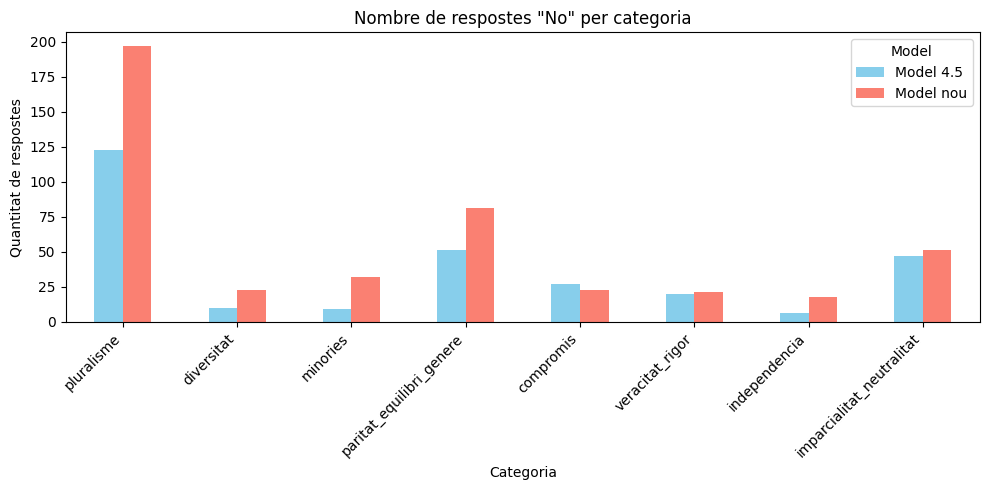

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

topic2_aligned = topic2.reindex(index=topic1.index).fillna(0)

topic1_no = topic1['No']
topic2_no = topic2_aligned['No']

# Creamos un DataFrame combinado
df_plot = pd.DataFrame({
    'Model 4.5': topic1_no,
    'Model nou': topic2_no
})

# Hacemos el gráfico
df_plot.plot(kind='bar', figsize=(10, 5), color=['skyblue', 'salmon'])

plt.title('Nombre de respostes "No" per categoria')
plt.xlabel('Categoria')
plt.ylabel('Quantitat de respostes')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model')
plt.tight_layout()
plt.show()


In [25]:
# Anem a veure-ho detalladament on hi ha diferències
from collections import Counter

# Inicialitzem el comptador
criteri_contradiccions = Counter()

for article_id in ids:
    if article_id in data_4_5_filtrat and article_id in data_nou:
        for key in data_4_5_filtrat[article_id]:
            if key not in data_nou[article_id]:
                continue
            
            compliment1 = data_4_5_filtrat[article_id][key]['compliment']
            compliment2 = data_nou[article_id][key]['compliment']

            if compliment1 != compliment2 and compliment1 != "No aplica" and compliment2 != "No aplica":
                criteri_contradiccions[key] += 1


In [26]:
# Estadístiques per criteri
# Mostrem els resultats de forma clara
nombre_noticies = len(data_4_5_filtrat)
print("\n Nombre de contradiccions per criteri (excloent 'No aplica'):\n")
for criteri, count in criteri_contradiccions.most_common():
    numero_correctes = nombre_noticies - count
    percentatge_correctes = round(numero_correctes / nombre_noticies * 100, 2)
    print(f"🔸 {criteri}: {percentatge_correctes}% correctes ({count} contradiccions)")


 Nombre de contradiccions per criteri (excloent 'No aplica'):

🔸 imparcialitat_neutralitat: 86.8% correctes (47 contradiccions)
🔸 pluralisme: 89.04% correctes (39 contradiccions)
🔸 compromis: 95.22% correctes (17 contradiccions)
🔸 paritat_equilibri_genere: 95.22% correctes (17 contradiccions)
🔸 veracitat_rigor: 95.79% correctes (15 contradiccions)
🔸 independencia: 97.19% correctes (10 contradiccions)
🔸 diversitat: 97.47% correctes (9 contradiccions)
🔸 minories: 98.31% correctes (6 contradiccions)


Available styles: ['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


C:\Users\marti\AppData\Local\Temp\ipykernel_8072\3798434867.py:43: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\marti\anaconda3\envs\playground_3cat\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


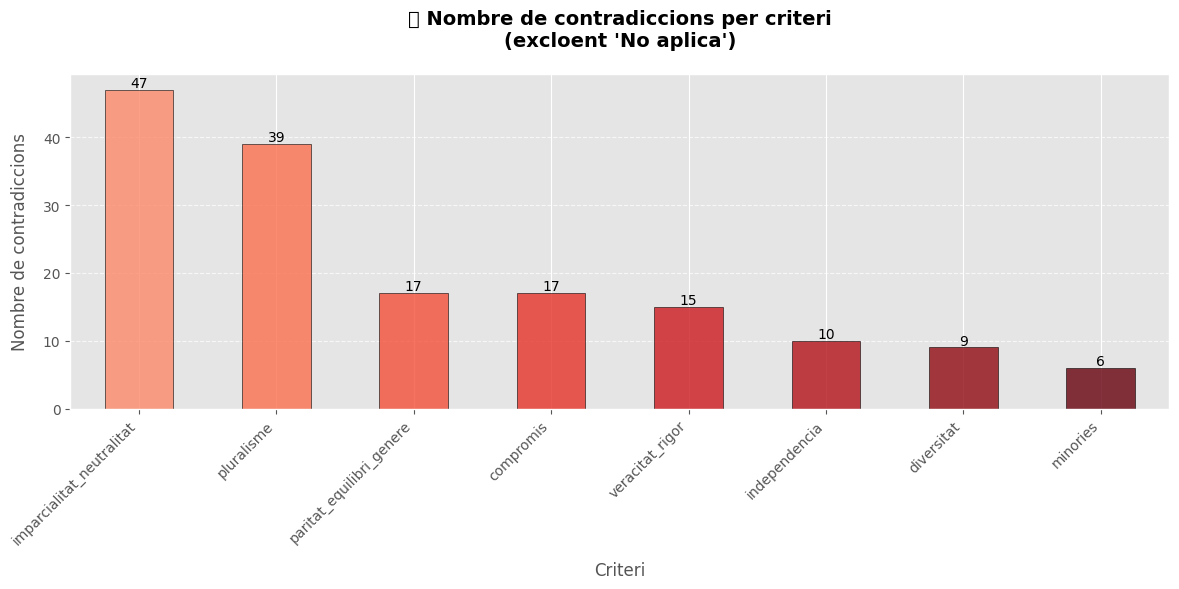

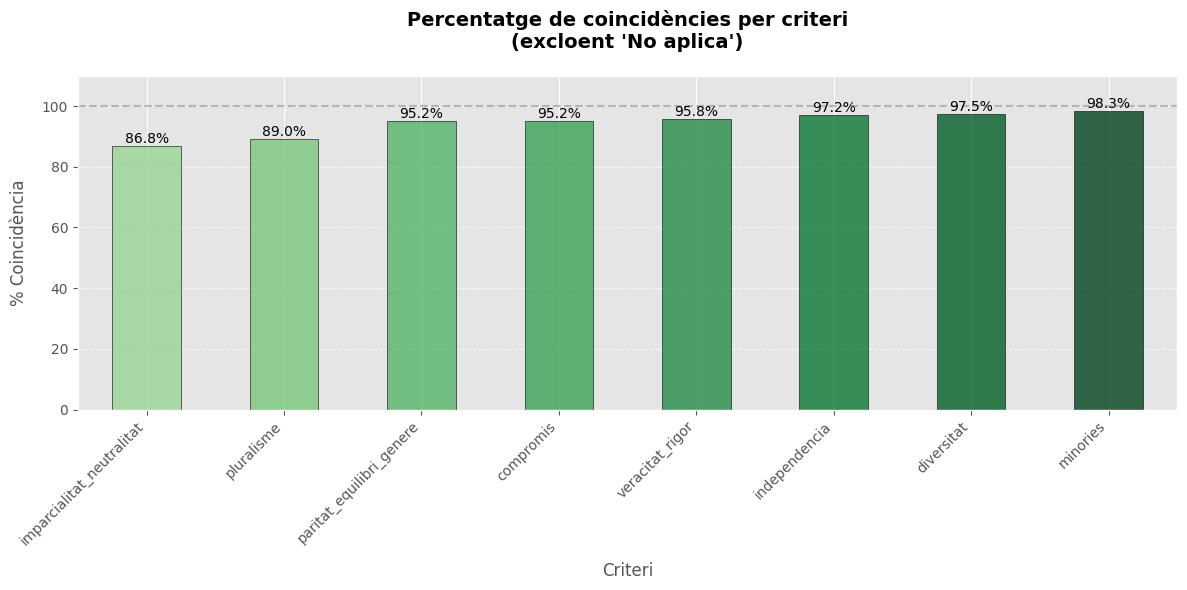

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Check available styles and use the first one that looks good
available_styles = plt.style.available
print("Available styles:", available_styles)  # This will show you what's available

# Use a modern style that exists in your environment (commonly 'ggplot', 'seaborn-v0_8', etc.)
# If 'seaborn' isn't available, try these alternatives:
plt.style.use('ggplot')  # or 'seaborn-v0_8', 'fivethirtyeight', 'tableau-colorblind10'

# Convertim el Counter a DataFrame
df_contradiccions = pd.DataFrame.from_dict(criteri_contradiccions, orient='index', columns=['Contradiccions'])
df_contradiccions['Correctes'] = nombre_noticies - df_contradiccions['Contradiccions']
df_contradiccions['% Correctes'] = (df_contradiccions['Correctes'] / nombre_noticies * 100).round(2)

# Ordenem per més contradiccions
df_contradiccions = df_contradiccions.sort_values('Contradiccions', ascending=False)

# Create a color gradient for the bars
colors_contradiccions = plt.cm.Reds(np.linspace(0.4, 1, len(df_contradiccions)))
colors_correctes = plt.cm.Greens(np.linspace(0.4, 1, len(df_contradiccions)))

# GRÀFIC 1: Nombre de contradiccions per criteri
plt.figure(figsize=(12, 6))
ax1 = df_contradiccions['Contradiccions'].plot(kind='bar', color=colors_contradiccions, edgecolor='black', alpha=0.8)
plt.title("Nombre de contradiccions per criteri\n(excloent 'No aplica')", fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Criteri", fontsize=12, labelpad=10)
plt.ylabel("Nombre de contradiccions", fontsize=12, labelpad=10)

# Add value labels on top of bars
for p in ax1.patches:
    ax1.annotate(f"{int(p.get_height())}", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points',
                fontsize=10)

# Improve grid and layout
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# GRÀFIC 2: Percentatge de coincidències per criteri
plt.figure(figsize=(12, 6))
ax2 = df_contradiccions['% Correctes'].plot(kind='bar', color=colors_correctes, edgecolor='black', alpha=0.8)
plt.title("Percentatge de coincidències per criteri\n(excloent 'No aplica')", fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Criteri", fontsize=12, labelpad=10)
plt.ylabel("% Coincidència", fontsize=12, labelpad=10)
plt.ylim(0, 110)  # Give some extra space at the top for annotations

# Add value labels on top of bars
for p in ax2.patches:
    ax2.annotate(f"{p.get_height():.1f}%", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points',
                fontsize=10)

# Add a horizontal line at 100% for reference
plt.axhline(y=100, color='gray', linestyle='--', alpha=0.5)

# Improve grid and layout
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()